In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate, optimize, spatial
from matplotlib import animation, rc
import sympy as sp
import pandas as pd
from PMD import PMD, distances
sp.init_printing(use_latex = "mathjax")
rc('animation', html='html5')
%matplotlib nbagg

# Molecular Dynamics

Atomic simulation using the Morse potential

https://en.wikipedia.org/wiki/Morse_potential

In [2]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/7/7a/Morse-potential.png", width=500, height=500)

## PMD module

PMD module available here: [PMD.py](./PMD.py)


## Potential

In [3]:
De, a, re, r = sp.symbols("D_e a r_e r")
V = De * (1- sp.exp(-a * (r-re)))**2
V

                     2
   ⎛     -a⋅(r - rₑ)⎞ 
Dₑ⋅⎝1 - ℯ           ⎠ 

## Force

In [4]:
F = -V.diff(r)
F

        ⎛     -a⋅(r - rₑ)⎞  -a⋅(r - rₑ)
-2⋅Dₑ⋅a⋅⎝1 - ℯ           ⎠⋅ℯ           

## Plotting


<IPython.core.display.Javascript object>


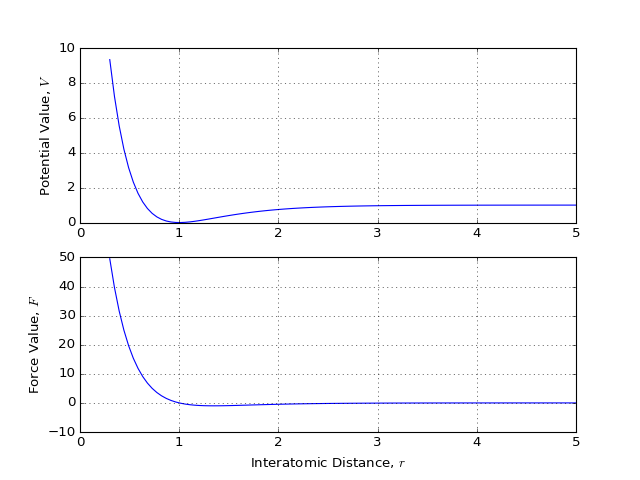

In [5]:
values = {De:1., a:2., re:1}
Vf = sp.lambdify(r, V.subs(values), "numpy")
Ff = sp.lambdify(r, F.subs(values), "numpy")
vr = np.linspace(.3 * values[re], 5 * values[re], 100)
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.plot(vr, Vf(vr))
plt.grid()
plt.ylabel("Potential Value, $V$")
ax = fig.add_subplot(2,1,2)
plt.plot(vr, Ff(vr))
plt.grid()
plt.xlabel("Interatomic Distance, $r$")
plt.ylabel("Force Value, $F$")
plt.show()

In [35]:
class MD(PMD):
    """
    Molecular dynamics w. Morse potential.
    """ 
    
    def __init__(self, De = 1., a = 1., re = 1., mu = 0., **kwargs):
        self.De = De
        self.a  = a
        self.re = re
        self.mu = mu
        super().__init__(**kwargs)
    
    def derivative(self, X, t, cutoff_radius = 1.e-2):
        De, a, re, mu = self.De, self.a, self.re, self.mu
        n = len(m)
        P = X[:2 * n ].reshape(n ,2)
        V = X[ 2 * n:].reshape(n ,2)
        M = m * m[:, np.newaxis]
        D, R, U = distances(P)
        np.fill_diagonal(R, np.inf)
        if cutoff_radius > 0.: R = np.where(R > cutoff_radius, R, cutoff_radius)
        #F =((G * M * R**-2)[:,:,np.newaxis] * U).sum(axis = 0)
        F =((2. * De * a * ( 1. - np.exp(-a * (R - re)) ) * 
              np.exp(- a * (R - re)))[:,:,np.newaxis] * U).sum(axis = 0) - mu * (V**2).sum(axis=0)**1.5 * V
        A = (F.T /m).T
        X2 = X.copy()
        X2[:2*n ] = V.flatten()
        X2[ 2*n:] = A.flatten()
        return X2       
        
    def potential(self, P):
        De, a, re, mu = self.De, self.a, self.re, self.mu
        D, R, U = distances(P)
        return np.where(R != 0.,
             De * a * ( 1 - np.exp(-a * (R - re)))**2, 
             0.).sum() / 2.
       


<IPython.core.display.Javascript object>


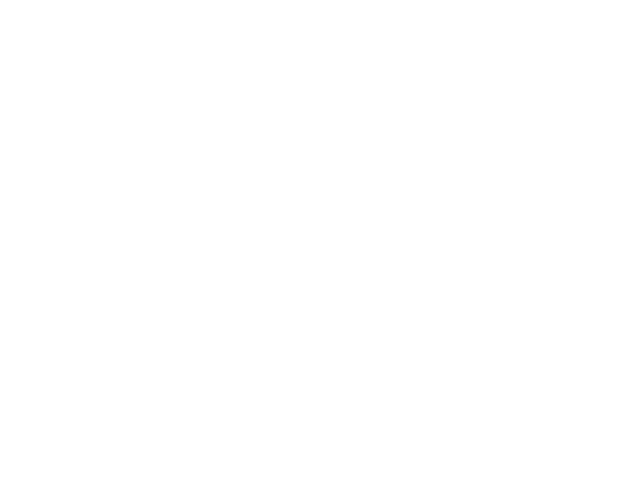

In [39]:
re = .5
nmx = 10
nmy = 10
nm = nmx * nmy
x0 = np.arange(nmx) * re * 1.2
y0 = np.arange(nmy) * re * 1.2
X0, Y0 = np.meshgrid(x0, y0)
P0 = np.array([X0.flatten(), Y0.flatten()]).T
P0 *= 1. + np.random.rand(*P0.shape) *.1
P0 -= P0.mean(axis = 0)
V0 = np.zeros_like(P0)
pcolors = "r"
tcolors = "b"
m = np.ones(nm)*1.e0
s = MD(m = m, P = P0, V = V0, mu = .05, re = re, a = 10, De = .5, nk = 1000)      
dt = 1.e-1
nt = 100


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
margin = 1.
plt.xlim(P0[:,0].min() - margin, P0[:,0].max() + margin)
plt.ylim(P0[:,1].min() - margin, P0[:,1].max() + margin)
plt.grid()
#ax.axis("off")
points = []

msize = 10. * (s.m / s.m.max())**(1./ 6.)
for i in range(nm):
    plc = len(pcolors)
    pc = pcolors[i%plc]
    tlc = len(tcolors)
    tc = tcolors[i%tlc]
    trail, = ax.plot([], [], "-"+tc)
    point, = ax.plot([], [], "o"+pc, markersize = msize[i])
    points.append(point)
    points.append(trail)

    
def init():
    for i in range(2 * nm):
        points[i].set_data([], [])
    return points 

def animate(i):
    s.solve(dt, nt)#, rtol = 1.e-8, atol = 1.e-8)
    x, y = s.xy()
    for i in range(nm):
        points[2*i].set_data(x[i:i+1], y[i:i+1])
        xt, yt = s.trail(i)
        points[2*i+1].set_data(xt, yt)
    return points

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=400, interval=20, blit=True)


#plt.show()
plt.close()
anim

## Microstructure analysis

In [40]:
P = s.positions
nodes = pd.DataFrame(P, columns = {"X", "Y"})
nodes.index.name = "Atom"
nodes.head()

,Y,X
Atom,,
0,-1.548040,-2.484607
1,-1.076637,-2.350997
2,-0.756620,-2.726322
3,-0.599794,-2.253769
4,-0.100450,-2.163847


In [41]:
tri = spatial.Delaunay(P)
tri.simplices
elements = pd.DataFrame(tri.simplices.copy())

<IPython.core.display.Javascript object>


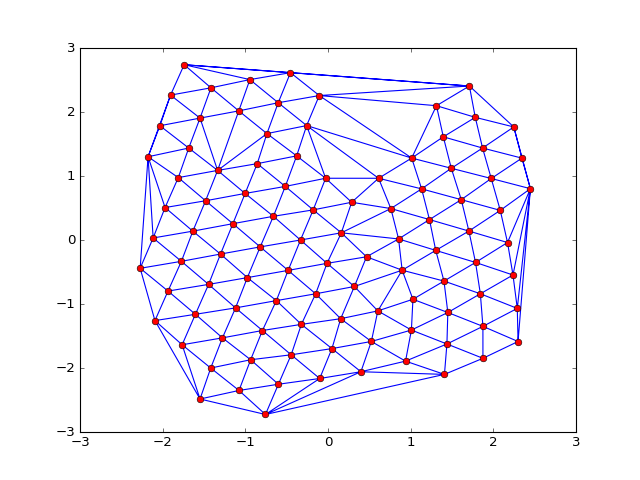

In [42]:
plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
plt.triplot(P[:,0], P[:,1], tri.simplices.copy())
plt.plot(P[:,0], P[:,1], 'o')
plt.show()